# Strategy Comparison

Compare multiple strategies side-by-side:
1. **Buy and Hold** - Passive benchmark
2. **Moving Average Crossover** - Technical strategy
3. **Momentum Rotation** - Active factor strategy

This notebook shows how to run multiple backtests and compare their performance.

## Setup

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from zipline import run_algorithm
from zipline.api import (
    order_target_percent,
    symbol,
    record,
    schedule_function,
    date_rules,
    time_rules,
    get_open_orders,
)

# Logging setup
logging.basicConfig(level=logging.WARNING, force=True)  # Reduce noise

# Common parameters
START_DATE = pd.Timestamp('2020-01-01')
END_DATE = pd.Timestamp('2023-12-31')
CAPITAL = 100000

print(f"Comparing strategies from {START_DATE.date()} to {END_DATE.date()}")
print(f"Starting capital: ${CAPITAL:,}")

Comparing strategies from 2020-01-01 to 2023-12-31
Starting capital: $100,000


## Strategy 1: Buy and Hold SPY

In [3]:
def initialize_buy_hold(context):
    context.spy = symbol('SPY')
    context.has_bought = False

def handle_data_buy_hold(context, data):
    if not context.has_bought and data.can_trade(context.spy):
        order_target_percent(context.spy, 1.0)
        context.has_bought = True
    record(portfolio_value=context.portfolio.portfolio_value)

print("Running Buy and Hold strategy...")
results_buy_hold = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize_buy_hold,
    handle_data=handle_data_buy_hold,
    capital_base=CAPITAL,
    data_frequency='daily',
    bundle='sharadar',
)
print("✓ Buy and Hold complete")

Running Buy and Hold strategy...
⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.
✓ Buy and Hold complete


## Strategy 2: Moving Average Crossover

In [4]:
FAST_MA = 50
SLOW_MA = 200

def initialize_ma_cross(context):
    context.stock = symbol('SPY')
    context.invested = False

def handle_data_ma_cross(context, data):
    # Only proceed if stock is tradeable
    if not data.can_trade(context.stock):
        return
    
    hist = data.history(context.stock, 'close', SLOW_MA + 1, '1d')
    
    fast_mavg = hist[-FAST_MA:].mean()
    slow_mavg = hist[-SLOW_MA:].mean()
    prev_fast = hist[-(FAST_MA+1):-1].mean()
    prev_slow = hist[-(SLOW_MA+1):-1].mean()
    
    golden_cross = (prev_fast <= prev_slow) and (fast_mavg > slow_mavg)
    death_cross = (prev_fast >= prev_slow) and (fast_mavg < slow_mavg)
    
    open_orders = get_open_orders()
    
    if golden_cross and not context.invested and not open_orders:
        order_target_percent(context.stock, 1.0)
        context.invested = True
    elif death_cross and context.invested and not open_orders:
        order_target_percent(context.stock, 0.0)
        context.invested = False
    
    record(portfolio_value=context.portfolio.portfolio_value)

print("\nRunning MA Crossover strategy...")
results_ma_cross = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize_ma_cross,
    handle_data=handle_data_ma_cross,
    capital_base=CAPITAL,
    data_frequency='daily',
    bundle='sharadar',
)
print("✓ MA Crossover complete")


Running MA Crossover strategy...
✓ MA Crossover complete


## Strategy 3: Momentum Rotation

In [5]:
UNIVERSE = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA']
TOP_N = 3
MOMENTUM_WINDOW = 60

def initialize_momentum(context):
    context.universe = [symbol(s) for s in UNIVERSE]
    schedule_function(
        rebalance_momentum,
        date_rules.month_start(),
        time_rules.market_open(hours=1)
    )

def rebalance_momentum(context, data):
    # Filter for tradeable stocks only
    tradeable_universe = [stock for stock in context.universe if data.can_trade(stock)]
    
    if len(tradeable_universe) == 0:
        return
    
    prices = data.history(tradeable_universe, 'close', MOMENTUM_WINDOW + 1, '1d')
    momentum = (prices.iloc[-1] / prices.iloc[0]) - 1
    
    # Get top N from tradeable stocks
    top_n = min(TOP_N, len(tradeable_universe))
    top_stocks = momentum.nlargest(top_n).index
    target_weight = 1.0 / len(top_stocks)
    
    for stock in context.universe:
        if not data.can_trade(stock):
            continue  # Skip untradeable stocks
        
        if stock in top_stocks:
            order_target_percent(stock, target_weight)
        else:
            order_target_percent(stock, 0.0)

def handle_data_momentum(context, data):
    record(portfolio_value=context.portfolio.portfolio_value)

print("\nRunning Momentum Rotation strategy...")
results_momentum = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize_momentum,
    handle_data=handle_data_momentum,
    capital_base=CAPITAL,
    data_frequency='daily',
    bundle='sharadar',
)
print("✓ Momentum Rotation complete")


Running Momentum Rotation strategy...
✓ Momentum Rotation complete


## Compare Portfolio Values

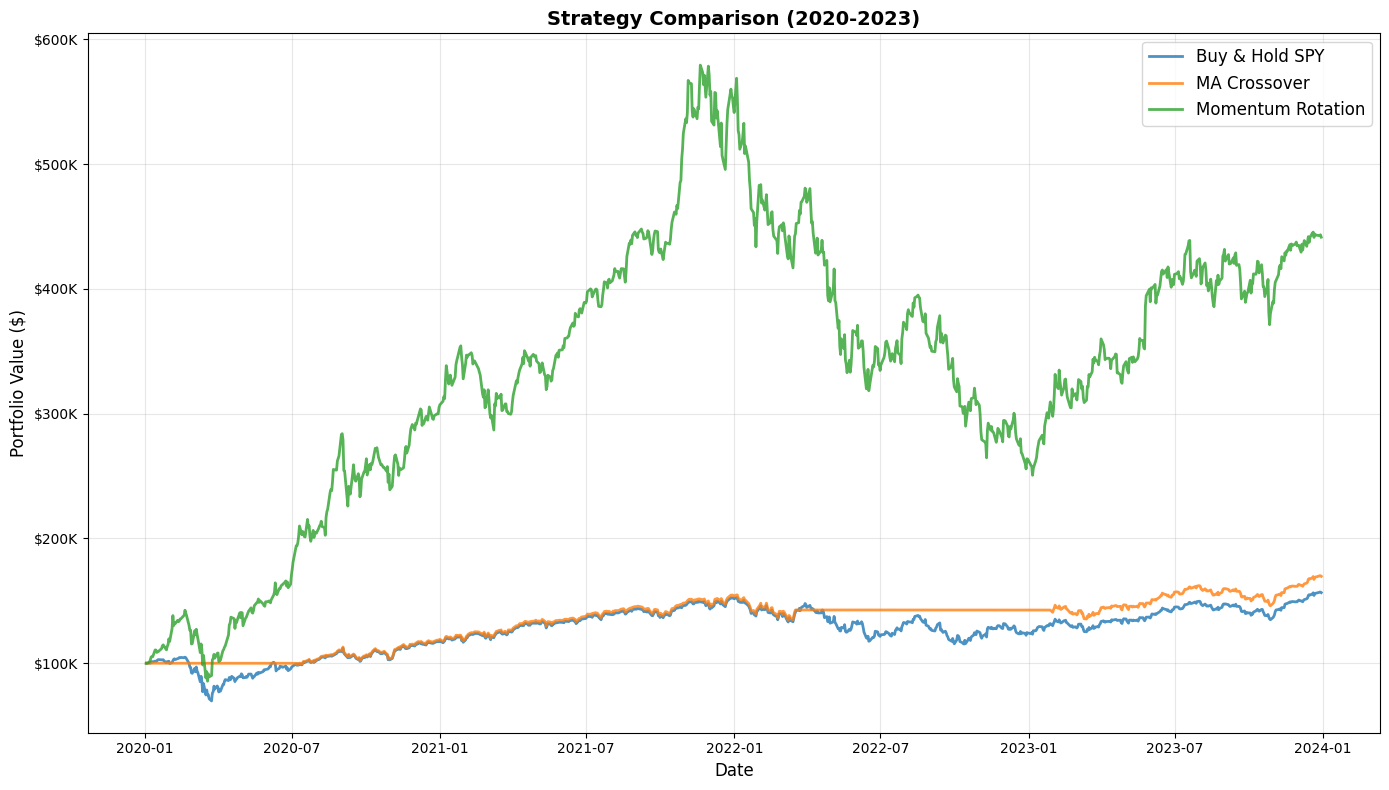

In [6]:
# Plot all strategies
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(results_buy_hold.index, results_buy_hold['portfolio_value'], 
        label='Buy & Hold SPY', linewidth=2, alpha=0.8)
ax.plot(results_ma_cross.index, results_ma_cross['portfolio_value'], 
        label='MA Crossover', linewidth=2, alpha=0.8)
ax.plot(results_momentum.index, results_momentum['portfolio_value'], 
        label='Momentum Rotation', linewidth=2, alpha=0.8)

ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Strategy Comparison (2020-2023)', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Performance Metrics Comparison

In [7]:
def calculate_metrics(results, name):
    """
    Calculate performance metrics for a strategy.
    """
    total_return = ((results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0]) - 1) * 100
    
    daily_returns = results['portfolio_value'].pct_change().dropna()
    annual_return = ((1 + daily_returns.mean()) ** 252 - 1) * 100
    annual_vol = daily_returns.std() * np.sqrt(252) * 100
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    
    # Max drawdown
    cummax = results['portfolio_value'].cummax()
    drawdown = (results['portfolio_value'] / cummax) - 1
    max_drawdown = drawdown.min() * 100
    
    # Sortino ratio (downside deviation)
    downside_returns = daily_returns[daily_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (daily_returns.mean() * 252) / downside_std if downside_std > 0 else 0
    
    # Win rate
    win_rate = (daily_returns > 0).sum() / len(daily_returns) * 100
    
    return {
        'Strategy': name,
        'Total Return (%)': total_return,
        'Annual Return (%)': annual_return,
        'Annual Volatility (%)': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Win Rate (%)': win_rate,
        'Final Value ($)': results['portfolio_value'].iloc[-1],
    }

# Calculate metrics for all strategies
metrics = pd.DataFrame([
    calculate_metrics(results_buy_hold, 'Buy & Hold'),
    calculate_metrics(results_ma_cross, 'MA Crossover'),
    calculate_metrics(results_momentum, 'Momentum Rotation'),
])

print("\n" + "="*100)
print("PERFORMANCE COMPARISON")
print("="*100)
print(metrics.to_string(index=False))
print("="*100)


PERFORMANCE COMPARISON
         Strategy  Total Return (%)  Annual Return (%)  Annual Volatility (%)  Sharpe Ratio  Sortino Ratio  Max Drawdown (%)  Win Rate (%)  Final Value ($)
       Buy & Hold         56.592198          14.771183              22.456211      0.613674       0.759743        -33.460239     53.731343    156592.197555
     MA Crossover         69.676401          14.990376              11.922157      1.171910       1.384776        -12.997129     36.716418    169676.400630
Momentum Rotation        341.517826          57.561562              40.526692      1.122856       1.549320        -56.737302     53.432836    441517.826168


## Visualize Key Metrics

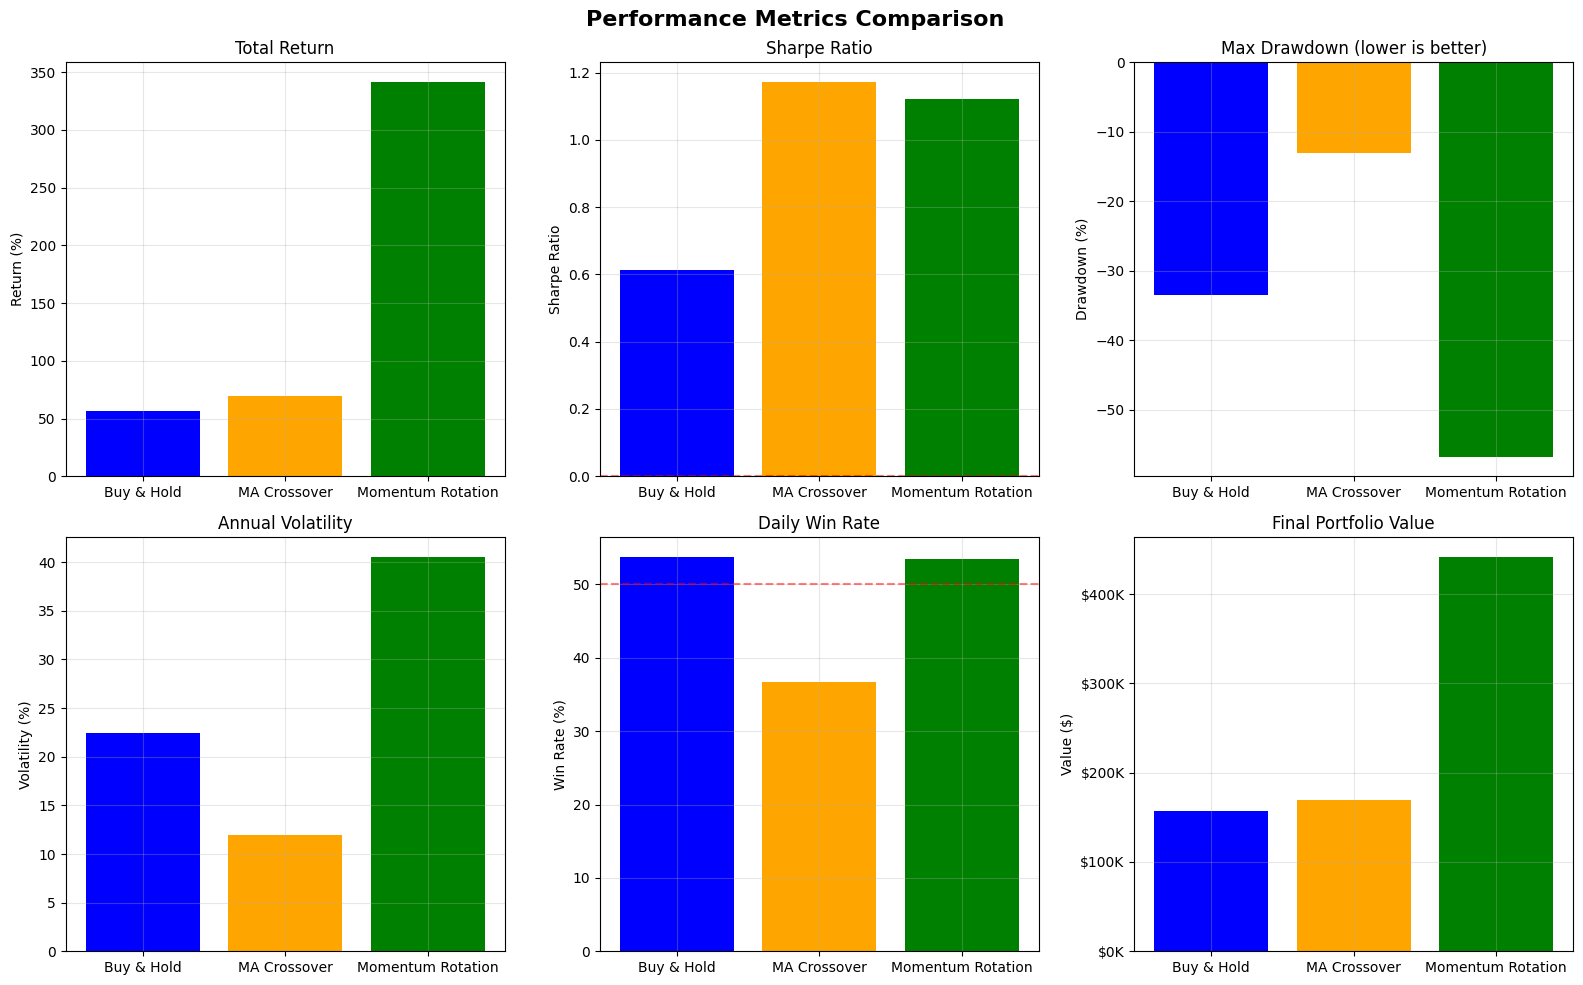

In [8]:
# Create comparison charts
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Performance Metrics Comparison', fontsize=16, fontweight='bold')

# Total Return
axes[0, 0].bar(metrics['Strategy'], metrics['Total Return (%)'], color=['blue', 'orange', 'green'])
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].set_title('Total Return')
axes[0, 0].grid(True, alpha=0.3)

# Sharpe Ratio
axes[0, 1].bar(metrics['Strategy'], metrics['Sharpe Ratio'], color=['blue', 'orange', 'green'])
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].set_title('Sharpe Ratio')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Max Drawdown
axes[0, 2].bar(metrics['Strategy'], metrics['Max Drawdown (%)'], color=['blue', 'orange', 'green'])
axes[0, 2].set_ylabel('Drawdown (%)')
axes[0, 2].set_title('Max Drawdown (lower is better)')
axes[0, 2].grid(True, alpha=0.3)

# Annual Volatility
axes[1, 0].bar(metrics['Strategy'], metrics['Annual Volatility (%)'], color=['blue', 'orange', 'green'])
axes[1, 0].set_ylabel('Volatility (%)')
axes[1, 0].set_title('Annual Volatility')
axes[1, 0].grid(True, alpha=0.3)

# Win Rate
axes[1, 1].bar(metrics['Strategy'], metrics['Win Rate (%)'], color=['blue', 'orange', 'green'])
axes[1, 1].set_ylabel('Win Rate (%)')
axes[1, 1].set_title('Daily Win Rate')
axes[1, 1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1, 1].grid(True, alpha=0.3)

# Final Value
axes[1, 2].bar(metrics['Strategy'], metrics['Final Value ($)'], color=['blue', 'orange', 'green'])
axes[1, 2].set_ylabel('Value ($)')
axes[1, 2].set_title('Final Portfolio Value')
axes[1, 2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Risk-Adjusted Returns

Compare returns relative to risk taken.

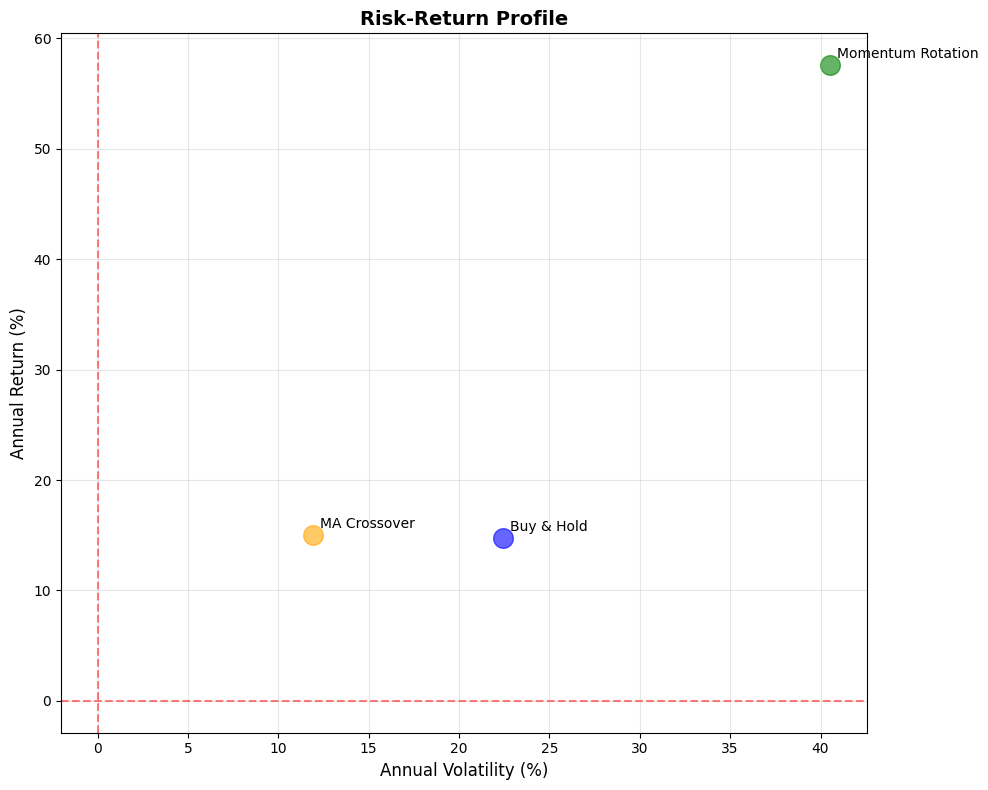


Risk-Return Analysis:
- Higher return with lower volatility is better (upper-left)
- Sharpe ratio measures this trade-off


In [9]:
# Risk-return scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'orange', 'green']
for i, row in metrics.iterrows():
    ax.scatter(
        row['Annual Volatility (%)'],
        row['Annual Return (%)'],
        s=200,
        c=colors[i],
        alpha=0.6,
        label=row['Strategy']
    )
    ax.annotate(
        row['Strategy'],
        (row['Annual Volatility (%)'], row['Annual Return (%)']),
        xytext=(5, 5),
        textcoords='offset points'
    )

ax.set_xlabel('Annual Volatility (%)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nRisk-Return Analysis:")
print("- Higher return with lower volatility is better (upper-left)")
print("- Sharpe ratio measures this trade-off")

## Cumulative Returns Comparison

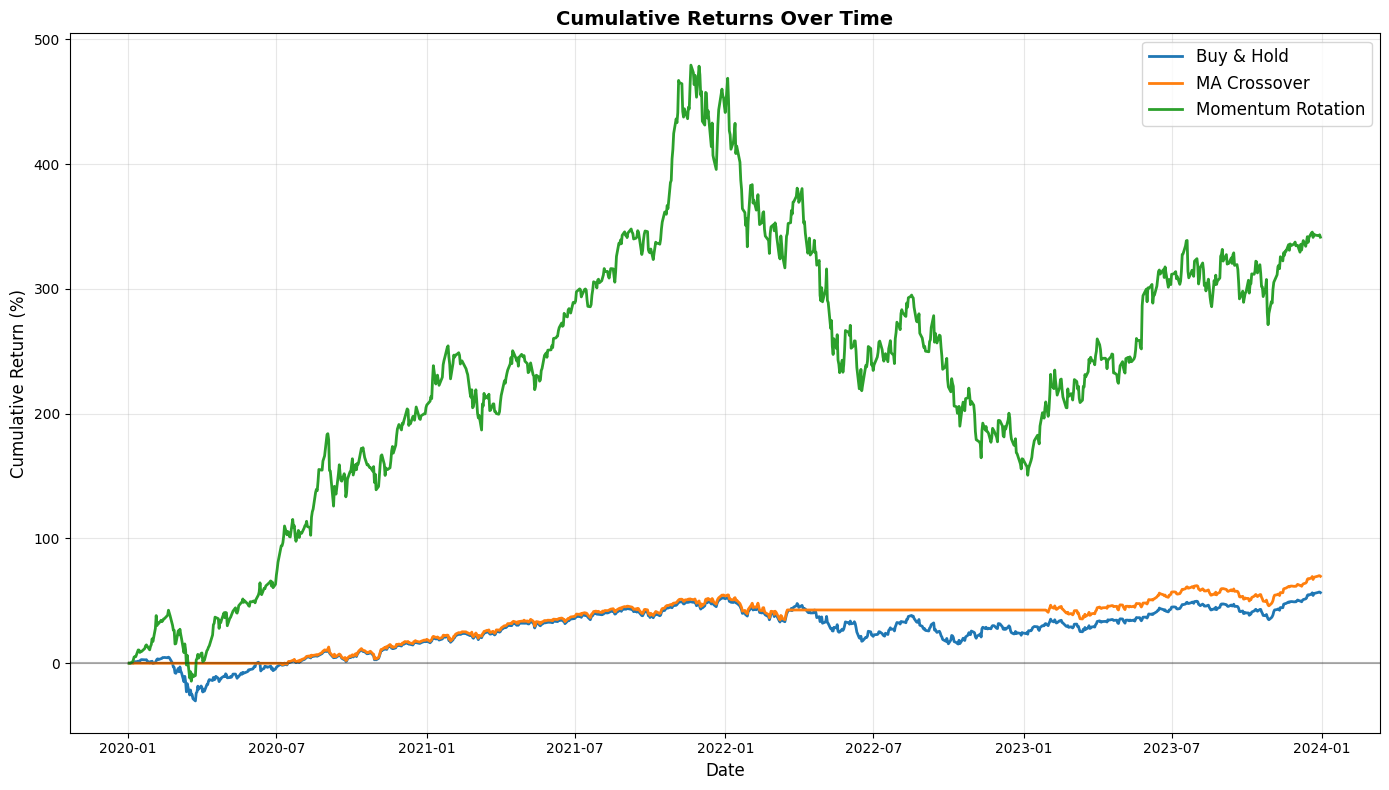

In [10]:
# Calculate cumulative returns
cum_returns_bh = (results_buy_hold['portfolio_value'] / CAPITAL - 1) * 100
cum_returns_ma = (results_ma_cross['portfolio_value'] / CAPITAL - 1) * 100
cum_returns_mom = (results_momentum['portfolio_value'] / CAPITAL - 1) * 100

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(cum_returns_bh.index, cum_returns_bh, label='Buy & Hold', linewidth=2)
ax.plot(cum_returns_ma.index, cum_returns_ma, label='MA Crossover', linewidth=2)
ax.plot(cum_returns_mom.index, cum_returns_mom, label='Momentum Rotation', linewidth=2)

ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Cumulative Returns Over Time', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

**From this comparison, consider:**

1. **Risk-Adjusted Returns** - Sharpe ratio shows return per unit of risk
2. **Drawdowns** - Maximum loss from peak (risk tolerance)
3. **Consistency** - Win rate and volatility
4. **Market Conditions** - Different strategies work in different markets

**No single "best" strategy:**
- Buy & Hold: Low maintenance, market exposure
- MA Crossover: Risk management, trend following
- Momentum: Active management, higher returns potential

**Next Steps:**
1. Test on different time periods
2. Add more strategies
3. Combine strategies (ensemble approach)
4. Add transaction costs for realistic comparison
5. Test on different market regimes (bull, bear, sideways)

## Export Comparison Data

In [11]:
# Save metrics to CSV
# metrics.to_csv('strategy_comparison.csv', index=False)

# Save combined results
# combined = pd.DataFrame({
#     'Buy_Hold': results_buy_hold['portfolio_value'],
#     'MA_Cross': results_ma_cross['portfolio_value'],
#     'Momentum': results_momentum['portfolio_value'],
# })
# combined.to_csv('portfolio_values.csv')

print("\nTo save comparison data, uncomment the lines above.")


To save comparison data, uncomment the lines above.
